# Inverse model on FetchNoTask

## Instanciate and train the model

Create the environment.

In [17]:
import gym
import gym_robotics
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage

env = VecTransposeImage(
    make_vec_env(
        "__root__/FetchNoTask-v1",
        env_kwargs=dict(image_obs_space=True),
    )
)

Initilize the device.

In [18]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [19]:
import numpy as np
from stable_baselines3.common.buffers import ReplayBuffer

from copy import deepcopy


def collect_rollouts(n, env, replay_buffer):
    num_timesteps = 0
    last_obs = env.reset()

    while num_timesteps < n:
        # Select action randomly or according to policy
        actions = np.array([env.action_space.sample()])

        # Rescale and perform action
        new_obs, rewards, dones, infos = env.step(actions)

        num_timesteps += env.num_envs
        # Avoid modification by reference
        next_obs = deepcopy(new_obs)

        # As the VecEnv resets automatically, new_obs is already the
        # first observation of the next episode
        for i, done in enumerate(dones):
            if done and infos[i].get("terminal_observation") is not None:
                next_obs[i] = infos[i]["terminal_observation"]

        replay_buffer.add(
            last_obs,
            next_obs,
            actions,
            rewards,
            dones,
            infos,
        )

        last_obs = new_obs


train_buffer = ReplayBuffer(
    10_000,
    env.observation_space,
    env.action_space,
    device=device,
)
test_buffer = ReplayBuffer(
    1_000,
    env.observation_space,
    env.action_space,
    device=device,
)

collect_rollouts(10_000, env, train_buffer)
collect_rollouts(1_000, env, test_buffer)

In [20]:
train_buffer.pos

0

Instanciate the model and the optimizer.

In [21]:
from lge.inverse_model import ConvInverseModel

from torch import optim

inverse_model = ConvInverseModel(action_size=env.action_space.shape[0], latent_size=64).to(device)
optimizer = optim.Adam(inverse_model.parameters(), lr=1e-3)

Train the model.

In [22]:
import torch.nn.functional as F


for epoch in range(3_000):
    # Sample
    sample = train_buffer.sample(32)
    observations = sample.observations.float() / 255
    next_observations = sample.next_observations.float() / 255
    actions = sample.actions

    # Compute the output image
    inverse_model.train()
    pred_actions = inverse_model(observations, next_observations)

    # Compute the loss
    loss = F.mse_loss(pred_actions, actions)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        sample = test_buffer.sample(32)
        observations = sample.observations.float() / 255
        next_observations = sample.next_observations.float() / 255
        actions = sample.actions

        # Compute the output image
        inverse_model.eval()
        pred_actions = inverse_model(observations, next_observations)
        # Compute the loss
        test_loss = F.mse_loss(pred_actions, actions)
        print("epoch: {:5d}\tprediction loss: train {:.5f}, test: {:.5f} ".format(epoch, loss.item(), test_loss.item()))

epoch:     0	prediction loss: train 0.28007, test: 0.37901 
epoch:   100	prediction loss: train 0.32289, test: 0.32507 
epoch:   200	prediction loss: train 0.29163, test: 0.38265 
epoch:   300	prediction loss: train 0.31497, test: 0.33771 
epoch:   400	prediction loss: train 0.25974, test: 0.24013 
epoch:   500	prediction loss: train 0.20154, test: 0.18621 
epoch:   600	prediction loss: train 0.18039, test: 0.15986 
epoch:   700	prediction loss: train 0.19056, test: 0.18834 
epoch:   800	prediction loss: train 0.17010, test: 0.18471 
epoch:   900	prediction loss: train 0.19071, test: 0.16275 
epoch:  1000	prediction loss: train 0.16842, test: 0.15825 
epoch:  1100	prediction loss: train 0.15867, test: 0.20894 
epoch:  1200	prediction loss: train 0.18944, test: 0.17452 
epoch:  1300	prediction loss: train 0.19739, test: 0.17596 
epoch:  1400	prediction loss: train 0.17995, test: 0.20506 
epoch:  1500	prediction loss: train 0.14707, test: 0.21014 
epoch:  1600	prediction loss: train 0.19

See the result for one transition.

true action		 [-0.65865135 -0.61914843 -0.21977454 -0.4925384 ]
predicted action	 [-0.46685636 -0.5837856  -0.22674772 -0.00502674]


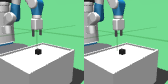

In [23]:
from PIL import Image
from IPython.display import display

# Sample one transition
sample = test_buffer.sample(1)
observations = sample.observations.float() / 255
next_observations = sample.next_observations.float() / 255
actions = sample.actions

# Predict the action
inverse_model.eval()
pred_actions = inverse_model(observations, next_observations)

# See the result
print("true action\t\t", actions.squeeze().detach().cpu().numpy())
print("predicted action\t", pred_actions.squeeze().detach().cpu().numpy())


observation = sample.observations.squeeze().moveaxis(0, 2).detach().cpu().numpy()
next_observation = sample.next_observations.squeeze().moveaxis(0, 2).detach().cpu().numpy()
img = np.hstack((observation, next_observation))
img = Image.fromarray(img)
display(img)